In [1]:
import numpy as np
import pandas as pd
import datetime
import os

import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.figure(figsize=(12, 5))

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [3]:
# 读取数据
train = pd.read_csv("input/train.csv", nrows=10000000)
test = pd.read_csv("input/test.csv")

In [4]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [5]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [6]:
variables = ["ip", "app", "device", "os", "channel"]
for v in variables:
    train[v] = train[v].astype('category')
    test[v] = test[v].astype('category')

In [7]:
# 转换click_time 和 attributed_time为timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

train['is_attributed'] = train['is_attributed'].astype('category')

In [8]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000,18717,10000000.0
unique,68740.0,332.0,940.0,292.0,170.0,29943,15698,2.0
top,73516.0,12.0,1.0,19.0,245.0,2017-11-06 16:05:10,2017-11-06 23:36:23,0.0
freq,51711.0,1291185.0,9381146.0,2410148.0,793105.0,1261,6,9981283.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-07 00:12:03,2017-11-07 15:59:53,NaN


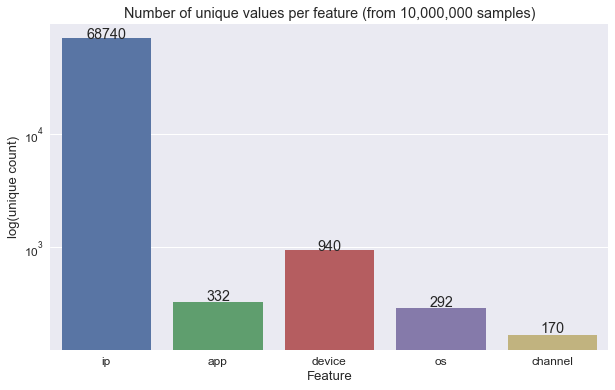

In [9]:
# 统计相应列不同取值的数量
plt.figure(figsize=(10, 6))
cols =['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 10,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
           height + 10,
           uniq, ha="center")

In [10]:
train[['attributed_time', 'is_attributed']][train['is_attributed'] == 1].describe()

,attributed_time,is_attributed
count,18717,18717.0
unique,15698,1.0
top,2017-11-06 23:36:23,1.0
freq,6,18717.0
first,2017-11-06 16:00:47,NaN
last,2017-11-07 15:59:53,NaN


## 观察
1.只有18717个attributed_time值。意味着10,000,000个点击中只有18717次才有下载。少于0.2%。
2.有ip地址触发点击超过5万次。 似乎奇怪的是，一个IP地址通常会在短短4天的时间内点击。 这是否意味着编码的IP地址不是设备ID，而是网络ID？ （在下面探讨）
3.在训练集中首次点击是在2017-11-06 14：32：21.在测试集中从2017-11-10开始。根据数据，训练苏剧覆盖四天。这意味着训练数据和测试数据不重叠，但测试数据是在训练数据结束后的第二天提取的。训练数据按时间戳排序，（
4.2017-11-06是星期一。 2017-11-10是星期五。 即训练数据是Mon-Thur，测试数据是星期五 - 测试中没有丢失的数据。 列车中缺失的值似乎仅适用于由于没有应用程序下载而没有任何值的attribution_time。

In [11]:
test['click_id'] = test['click_id'].astype('category')
test.describe()

,click_id,ip,app,device,os,channel,click_time
count,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469
unique,18790469.0,93936.0,417.0,1985.0,395.0,178.0,21603
top,18790468.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,182522.0,2872176.0,17360269.0,4334532.0,1214650.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 04:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 15:00:00


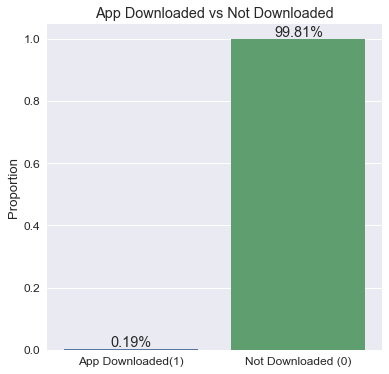

In [12]:
# 应用程序下载和没有下载的对比
plt.figure(figsize=(6, 6))
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded(1)', 'Not Downloaded (0)'], [mean, 1 - mean])
ax.set(ylabel='Proportion', title="App Downloaded vs Not Downloaded")
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha='center')

## 探索ip计数。 检查多个ips是否有任何下载。
此时我试图找出'ip'实际编码的内容。 我最初的理解是ips是用户特定的，并没有经得起审查。 如果ip重复了太多次，它是机器人吗？ 
这似乎不是真的，因为重复的ips确实转换了。 见下文：

In [13]:
# 统计训练数据中每个Ip的出现的次数
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,73516,51711
1,73487,51215
2,5314,35073
3,5348,35004
4,53454,25381
5,105560,23289
6,100275,23070
7,114276,22774
8,201182,22719
9,105475,22047


In [14]:
train = train.merge(temp, on='ip', how='left')

In [15]:
train[train['is_attributed'] == 1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
7912764,73516,34,1,19,243,2017-11-06 23:28:13,2017-11-07 01:13:45,1,51711
289189,73516,19,3033,21,213,2017-11-06 16:05:33,2017-11-06 16:05:52,1,51711
3350587,73516,72,1,18,101,2017-11-06 17:46:37,2017-11-07 09:46:44,1,51711
3416495,73516,10,1,25,377,2017-11-06 17:50:33,2017-11-06 18:50:59,1,51711
6331848,73516,29,1,14,213,2017-11-06 22:36:25,2017-11-07 02:10:05,1,51711
7543731,73516,155,1,19,213,2017-11-06 23:18:10,2017-11-07 15:07:40,1,51711
5144374,73516,9,1,37,234,2017-11-06 20:49:25,2017-11-06 20:53:19,1,51711
3651360,73516,107,1,19,171,2017-11-06 18:05:12,2017-11-06 23:44:44,1,51711
6368416,73516,10,1,13,377,2017-11-06 22:38:04,2017-11-06 22:52:43,1,51711
2073360,73516,9,1,13,134,2017-11-06 16:52:12,2017-11-06 16:52:20,1,51711


In [16]:
train[train['is_attributed'] == 1].ip.describe()

count     18717
unique    16112
top       73487
freq         56
Name: ip, dtype: int64

因此，高频率的ip计数会获得转换。 一个ip最多可下载56个。 每个IP必须适用于具有许多设备的某些网络。

In [17]:
train['is_attributed'] = train['is_attributed'].astype(int)

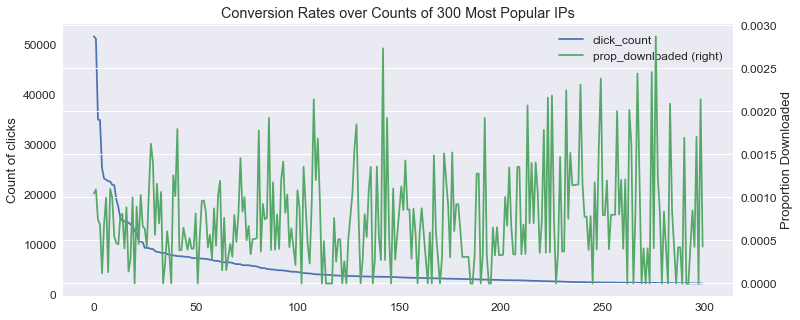

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0    73516        51711         0.001044
1    73487        51215         0.001093
2     5314        35073         0.000741
3     5348        35004         0.000686
4    53454        25381         0.000118
5   105560        23289         0.000687
6   100275        23070         0.000997
7   114276        22774         0.000132
8   201182        22719         0.001100
9   105475        22047         0.000998
10   95766        21966         0.000546
11   26995        19166         0.000470
12  209663        17605         0.000454
13   43793        15398         0.000779
14  137052        14840         0.000809
15   86767        14742         0.000407
16   17149        14673         0.000886
17  111025        14493         0.000138
18  138561        14119         0.000283
19  147957        14012         0.000999


In [18]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns =['ip', 'click_count', 'prop_downloaded']

ax =merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print ("Counversion Rates over Counts of Most Popular IPs")
print (merge[:20])

转换是带有噪声的，并且似乎与IP的流行程度无关。

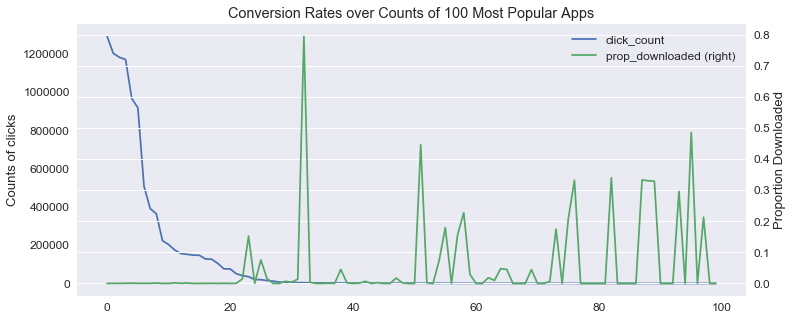

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0   12      1291185         0.000140
1    2      1202534         0.000388
2   15      1181585         0.000277
3    3      1170412         0.000630
4    9       966839         0.000869
5   18       917820         0.000397
6   14       507491         0.000483
7    1       391508         0.000350
8    8       364361         0.001441
9   21       223823         0.000089
10  13       203332         0.000103
11  20       174792         0.001962
12  24       156247         0.000550
13  11       152367         0.001503
14  23       148119         0.000027
15   6       147356         0.000176
16  64       127923         0.000258
17  26       126630         0.000537
18  25       104855         0.000095
19  27        76417         0.000523


In [19]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Counts of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print ('Counversion Rates over Counts of Most Popular Apps')
print (merge[:20])

每个应用的点击次数差异很大，只需点击一次应用，最多可达1300万。 随着计数下降，该比例会增加，因为每次额外点击对比例值的影响更大。 通常，对于计数为千的应用程序，该比率保持在0.0001 - 0.0015边界内。 对于不太流行的应用程序，它更广泛地融合。

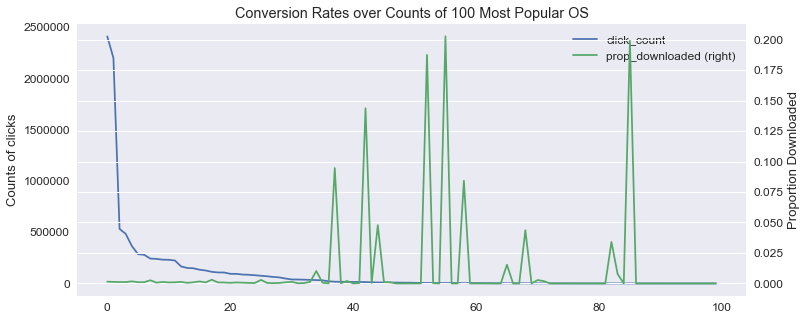

Counversion Rates over Counts of Most Popular OS
     os  click_count  prop_downloaded
0    19      2410148         0.001489
1    13      2199778         0.001271
2    17       531695         0.001155
3    18       483602         0.001115
4    22       365576         0.001729
5    10       285907         0.001011
6     8       279549         0.001037
7     6       242799         0.002619
8     9       239377         0.000656
9    25       232143         0.001206
10   15       230832         0.000853
11   20       223820         0.000920
12   16       166165         0.001258
13   37       151274         0.000509
14    3       147970         0.000919
15   14       134127         0.001663
16   41       126565         0.000877
17    1       113395         0.003042
18  607       107442         0.000856
19   12       107005         0.000757


In [20]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular OS')
ax.set(ylabel='Counts of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print ('Counversion Rates over Counts of Most Popular OS')
print (merge[:20])